https://youtu.be/3yk9sBja7YI

Training custom models for segmentation using StarDist

In [31]:
#https://www.youtube.com/watch?v=F6sfm1i8OfY
!pip install stardist
!pip install patool

 70/100 [====================>.........] - ETA: 5s - loss: 4.6014 - prob_loss: 0.3429 - dist_loss: 21.2925 - prob_kld: 0.1599 - dist_relevant_mae: 21.2907 - dist_relevant_mse: 1021.4864 - dist_dist_iou_metric: 0.2767

In [32]:
#imports
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
#matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt


from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.matching import matching, matching_dataset
from stardist.models import Config2D, StarDist2D, StarDistData2D

import tensorflow as tf
import scipy
import scipy.ndimage as ndi
import numpy as np
import skimage
from skimage import io, filters
from skimage import data, img_as_float
import skimage.util.noise as noise
from skimage.restoration import denoise_bilateral
import matplotlib.pyplot as plt
import os
import math

import skimage
from skimage import img_as_ubyte
from skimage import exposure
from skimage import filters
from skimage import io
from skimage import color
from skimage import feature
from skimage import segmentation
from skimage import morphology
import scipy.ndimage as ndi
import numpy as np
import matplotlib.pyplot as plt

from skimage import io, color, exposure, morphology, segmentation, img_as_float, restoration

%matplotlib inline


In [33]:
#Random color map labels 100, 700 wide and 650
np.random.seed(42)
lbl_cmap = random_label_cmap()

 72/100 [====================>.........] - ETA: 5s - loss: 4.6593 - prob_loss: 0.3430 - dist_loss: 21.5818 - prob_kld: 0.1597 - dist_relevant_mae: 21.5800 - dist_relevant_mse: 1065.5479 - dist_dist_iou_metric: 0.2764

In [34]:
import os
from glob import glob
#function to move our slices  to there respective folders. thank you brandon ^_^ saddly this is a leftover function not used

def move_file_set(src_dir: str, dest_dir: str, pattern: str) -> None:
    """
    Move all files in src_dir directory where the file name matches
    the given pattern to the dest_dir directory. Will print the
    number of files moved.
    :param src_dir: The absolute path for the source directory
    :param dest_dir: The absolute path for the destination directory
    :param pattern: A file name pattern to match against (* is wildcard)
                    Ex: to get all files with "move" in the filename,
                    pattern would be "*move*".
    :return: None
    """
    pattern = "*" if len(pattern) == 0 else pattern  # error checking
    move_count: int = 0
    for old_path in glob(os.path.join(src_dir, pattern)):
        new_path = os.path.join(dest_dir, os.path.basename(old_path))
        os.replace(old_path, new_path)
        move_count += 1
    print(f"Number of Files Move: {move_count}")


In [35]:
#ben's crop image function
def crop_images(original, mask, num_width, num_height, size):
    crops = []
    for i in range(num_height):
        for j in range(num_width):
            # Calculate the starting and ending indices for the crop
            start_x = j * size[0]
            start_y = i * size[1]
            end_x = start_x + size[0]
            end_y = start_y + size[1]

            # Crop the original and mask images to the same area using array slicing
            crop_original = original[start_y:end_y, start_x:end_x]
            crop_mask = mask[start_y:end_y, start_x:end_x]

            # Append the crops to the list
            crops.append({
                'original': crop_original,
                'mask': crop_mask,
                'position': (i, j)
            })

    return crops

In [36]:
#from google.colab import drive
#drive.mount('/gdrive')


In [37]:
import PIL
from PIL import Image
import numpy as n
import os, glob, math
import patoolib

newpath = r'testImages'
if not os.path.exists(newpath):
    patoolib.extract_archive("testImages.zip", outdir= os.getcwd())

newpath = r'originalDirectory_256x256'
if not os.path.exists(newpath):
    os.makedirs(newpath)

newpath = r'maskDirectory_256x256'
if not os.path.exists(newpath):
    os.makedirs(newpath)

imgDir2 = 'originalDirectory_256x256'
imgDir1 = 'maskDirectory_256x256'

# makes directories where files will be stored.
output_dir1 = os.path.join(os.getcwd(),imgDir1)
print(output_dir1)
output_dir2 = os.path.join(os.getcwd(),imgDir2)
print(output_dir2)


# Define the size of the crops
crop_size = (256, 256)

# Crop the images
OriginalImgPaths = []

for file in glob.glob("/content/testImages/originals/*.tif"):
                OriginalImgPaths.append(file)

print("OriginalImgPaths",OriginalImgPaths)

maskImgPaths = []

for file in glob.glob("/content/testImages/masks/*.tif"):
               maskImgPaths.append(file)

print("maskImgPaths",maskImgPaths)

for i in range(len(maskImgPaths)):

  original_img = io.imread(OriginalImgPaths[i])
  mask_img = io.imread(maskImgPaths[i])

 #apply some preprocessing to the original
  # Convert the image to float
  img_float = img_as_float(original_img)

  # Perform histogram equalization
  equalized_img = exposure.equalize_hist(img_float)

  # Apply additional contrast enhancement
  contrast_img = exposure.rescale_intensity(equalized_img)
  # Apply Chambolle denoising filter
  # The weight 'alpha' parameter controls the degree of smoothing.
  # alpha set to value of 0.05
  chambolle_img = restoration.denoise_tv_chambolle(contrast_img, weight=0.05)

  original_img = chambolle_img

  print("Shape of original image:", original_img.shape)
  print("Shape of mask image:", mask_img.shape)

  # Calculate the number of crops that fit into the images
  original_height, original_width = original_img.shape[:2]
  n_crops_width = original_width // crop_size[0]
  n_crops_height = original_height // crop_size[1]

  # Calculate the total number of 256x256 crops from the image
  total_crops = n_crops_width * n_crops_height
  print("\nTotal number of cropped images:", total_crops)

  # Print their values to see what we workin with lol
  print("original_height:", original_height)
  print("original_width:", original_width)
  print("n_crops_width:", n_crops_width)
  print("n_crops_height:", n_crops_height)

  crops = crop_images(original_img, mask_img, n_crops_width, n_crops_height, crop_size)

  output_files = []
  for i, crop in enumerate(crops):
      original_crop_path = f'/content/originalDirectory_256x256/original_crop{i}.tif'
      mask_crop_path = f'/content/maskDirectory_256x256/mask_crop{i}.tif'
      io.imsave(original_crop_path, crop['original'])
      io.imsave(mask_crop_path, crop['mask'])
      output_files.append((original_crop_path, mask_crop_path))


# Return the paths of the first few cropped images for display
#output_files[:5]  # Show paths of the first 5 sets of cropped images


/content/maskDirectory_256x256
/content/originalDirectory_256x256
 73/100 [====================>.........] - ETA: 5s - loss: 4.6514 - prob_loss: 0.3428 - dist_loss: 21.5430 - prob_kld: 0.1597 - dist_relevant_mae: 21.5412 - dist_relevant_mse: 1060.2643 - dist_dist_iou_metric: 0.2764OriginalImgPaths ['/content/testImages/originals/band_image.tif']
maskImgPaths ['/content/testImages/masks/band_image.tif']
100/100 [==============================] - 21s 208ms/step - loss: 4.6603 - prob_loss: 0.3417 - dist_loss: 21.5932 - prob_kld: 0.1590 - dist_relevant_mae: 21.5913 - dist_relevant_mse: 1058.3215 - dist_dist_iou_metric: 0.2758 - val_loss: 3.7945 - val_prob_loss: 0.2820 - val_dist_loss: 17.5627 - val_prob_kld: 0.1496 - val_dist_relevant_mae: 17.5609 - val_dist_relevant_mse: 575.5242 - val_dist_dist_iou_metric: 0.2961 - lr: 3.0000e-04
Epoch 18/20
 33/100 [========>.....................] - ETA: 14s - loss: 4.4432 - prob_loss: 0.3342 - dist_loss: 20.5447 - prob_kld: 0.1544 - dist_relevant_mae: 

 43/100 [===========>..................] - ETA: 11s - loss: 4.5184 - prob_loss: 0.3330 - dist_loss: 20.9272 - prob_kld: 0.1543 - dist_relevant_mae: 20.9254 - dist_relevant_mse: 1008.9762 - dist_dist_iou_metric: 0.2813original_img.shape (2028, 3523)
mask_img.shape (2028, 3523)
 60/100 [=================>............] - ETA: 7s - loss: 4.4474 - prob_loss: 0.3338 - dist_loss: 20.5676 - prob_kld: 0.1534 - dist_relevant_mae: 20.5658 - dist_relevant_mse: 946.0916 - dist_dist_iou_metric: 0.2833

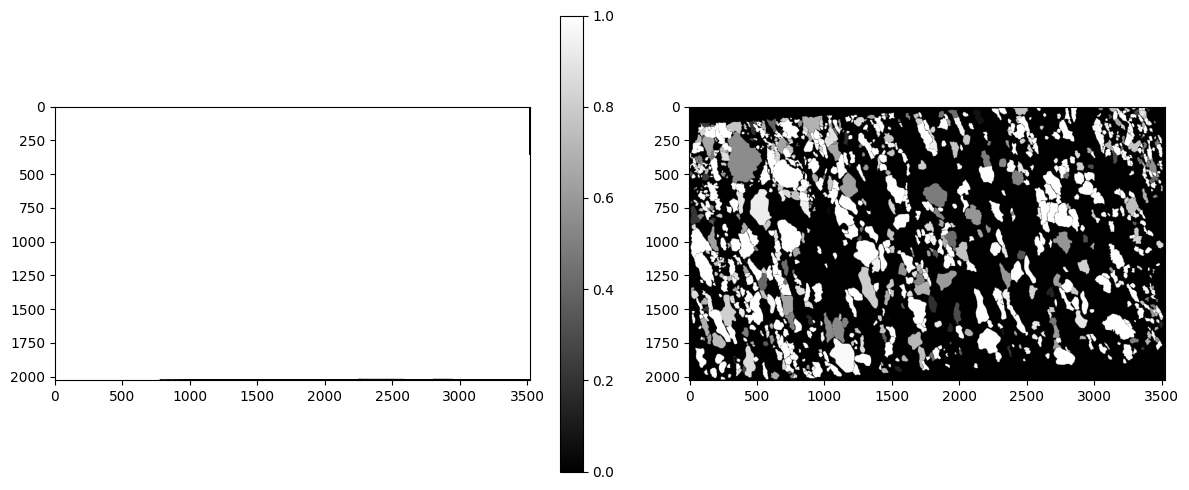

In [38]:

#original_img = io.imread('./cropped_band_image.png')
#mask_img = io.imread("./cropped_band_labels.png")

original_img = io.imread(OriginalImgPaths[0])
mask_img = io.imread(maskImgPaths[0])

#mask_img = mask_img > 150

# NOTE: Display result
fig, (ai,al) = plt.subplots(1,2, figsize=(12,5), gridspec_kw=dict(width_ratios=(1.25,1)))
im = ai.imshow(original_img, cmap='gray', clim=(0,1))
print("original_img.shape",original_img.shape)
#ai.set_title(img_title)
fig.colorbar(im, ax=ai)
al.imshow(mask_img,cmap='gray')
print("mask_img.shape",mask_img.shape)
#al.set_title(lbl_title)
plt.tight_layout()

In [39]:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           #Read input image and corresponding mask names
#X = sorted(glob('/content/drive/MyDrive/Colab Notebooks/data/mito_dataset_256x256/mito_images/*.tif'))
#Y = sorted(glob('/content/drive/MyDrive/Colab Notebooks/data/mito_dataset_256x256/mito_masks/*.tif'))
from glob import glob

image_paths = sorted(glob('/content/originalDirectory_256x256/*.tif'))
#print("X",X)
mask_paths = sorted(glob('/content/maskDirectory_256x256/*.tif'))

X = [io.imread(image_path) for image_path in image_paths]
Y = [io.imread(mask_path) for mask_path in mask_paths]

print("X[0].shape",X[0].shape)
print("Y[0].shape",Y[0].shape)

## fixes the size if the size of the original image is some whos skrewed up.
#for counter in range(0,len(X)):
    #X[counter] = X[counter][:,:,0:3]
    #print("X[counter].shape",X[counter].shape)

#use this incase the labes are 3dimentinal for some reason.
#for counter in range(0,len(Y)):

    #Y[counter] =Y[counter][:, :, 0]

print("X[0].shape",X[0].shape)
print("Y[0].shape",Y[0].shape)

n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]
#print("Y",Y)


 63/100 [=================>............] - ETA: 7s - loss: 4.4514 - prob_loss: 0.3347 - dist_loss: 20.5839 - prob_kld: 0.1536 - dist_relevant_mae: 20.5821 - dist_relevant_mse: 943.3417 - dist_dist_iou_metric: 0.2826X[0].shape (256, 256)
Y[0].shape (256, 256)
X[0].shape (256, 256)
Y[0].shape (256, 256)


In [40]:
#Normalize input images and fill holes in masks
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]
print("X[0].shape",X[0].shape,)
print("Y[0].shape",Y[0].shape,)

 64/100 [==================>...........] - ETA: 7s - loss: 4.4658 - prob_loss: 0.3351 - dist_loss: 20.6532 - prob_kld: 0.1536 - dist_relevant_mae: 20.6514 - dist_relevant_mse: 954.0875 - dist_dist_iou_metric: 0.2820

 14%|█▍        | 13/91 [00:00<00:00, 127.06it/s]

 65/100 [==================>...........] - ETA: 6s - loss: 4.4594 - prob_loss: 0.3342 - dist_loss: 20.6260 - prob_kld: 0.1535 - dist_relevant_mae: 20.6242 - dist_relevant_mse: 949.5262 - dist_dist_iou_metric: 0.2819

 41%|████      | 37/91 [00:00<00:00, 94.41it/s] 

 66/100 [==================>...........] - ETA: 6s - loss: 4.5348 - prob_loss: 0.3356 - dist_loss: 20.9961 - prob_kld: 0.1536 - dist_relevant_mae: 20.9943 - dist_relevant_mse: 1000.7423 - dist_dist_iou_metric: 0.2805

 52%|█████▏    | 47/91 [00:00<00:00, 75.28it/s]

 67/100 [===================>..........] - ETA: 6s - loss: 4.5273 - prob_loss: 0.3357 - dist_loss: 20.9579 - prob_kld: 0.1538 - dist_relevant_mae: 20.9561 - dist_relevant_mse: 996.2560 - dist_dist_iou_metric: 0.2805 

 79%|███████▉  | 72/91 [00:00<00:00, 122.38it/s]

 68/100 [===================>..........] - ETA: 6s - loss: 4.5360 - prob_loss: 0.3351 - dist_loss: 21.0047 - prob_kld: 0.1537 - dist_relevant_mae: 21.0029 - dist_relevant_mse: 998.6271 - dist_dist_iou_metric: 0.2804

  0%|          | 0/91 [00:00<?, ?it/s]

 69/100 [===================>..........] - ETA: 6s - loss: 4.5245 - prob_loss: 0.3355 - dist_loss: 20.9448 - prob_kld: 0.1536 - dist_relevant_mae: 20.9430 - dist_relevant_mse: 992.0129 - dist_dist_iou_metric: 0.2808

  5%|▌         | 5/91 [00:00<00:01, 43.35it/s]

 70/100 [====================>.........] - ETA: 5s - loss: 4.5136 - prob_loss: 0.3352 - dist_loss: 20.8921 - prob_kld: 0.1537 - dist_relevant_mae: 20.8903 - dist_relevant_mse: 986.0023 - dist_dist_iou_metric: 0.2809

 11%|█         | 10/91 [00:00<00:02, 28.37it/s]

 71/100 [====================>.........] - ETA: 5s - loss: 4.5031 - prob_loss: 0.3347 - dist_loss: 20.8419 - prob_kld: 0.1536 - dist_relevant_mae: 20.8401 - dist_relevant_mse: 979.8727 - dist_dist_iou_metric: 0.2808

 15%|█▌        | 14/91 [00:00<00:03, 24.85it/s]

 72/100 [====================>.........] - ETA: 5s - loss: 4.5104 - prob_loss: 0.3351 - dist_loss: 20.8767 - prob_kld: 0.1536 - dist_relevant_mae: 20.8749 - dist_relevant_mse: 982.7903 - dist_dist_iou_metric: 0.2807

 19%|█▊        | 17/91 [00:00<00:03, 20.60it/s]

 73/100 [====================>.........] - ETA: 5s - loss: 4.5025 - prob_loss: 0.3350 - dist_loss: 20.8373 - prob_kld: 0.1537 - dist_relevant_mae: 20.8354 - dist_relevant_mse: 977.5858 - dist_dist_iou_metric: 0.2807

 25%|██▌       | 23/91 [00:01<00:03, 19.54it/s]

 74/100 [=====================>........] - ETA: 5s - loss: 4.4881 - prob_loss: 0.3338 - dist_loss: 20.7717 - prob_kld: 0.1536 - dist_relevant_mae: 20.7699 - dist_relevant_mse: 970.4130 - dist_dist_iou_metric: 0.2807

 30%|██▉       | 27/91 [00:01<00:02, 22.12it/s]

 75/100 [=====================>........] - ETA: 4s - loss: 4.4729 - prob_loss: 0.3336 - dist_loss: 20.6963 - prob_kld: 0.1535 - dist_relevant_mae: 20.6945 - dist_relevant_mse: 962.7156 - dist_dist_iou_metric: 0.2811

 35%|███▌      | 32/91 [00:01<00:02, 27.73it/s]

 76/100 [=====================>........] - ETA: 4s - loss: 4.4844 - prob_loss: 0.3339 - dist_loss: 20.7525 - prob_kld: 0.1534 - dist_relevant_mae: 20.7507 - dist_relevant_mse: 968.7264 - dist_dist_iou_metric: 0.2810

 44%|████▍     | 40/91 [00:01<00:01, 25.92it/s]

 77/100 [======================>.......] - ETA: 4s - loss: 4.4855 - prob_loss: 0.3337 - dist_loss: 20.7589 - prob_kld: 0.1532 - dist_relevant_mae: 20.7571 - dist_relevant_mse: 967.0797 - dist_dist_iou_metric: 0.2810

 49%|████▉     | 45/91 [00:01<00:01, 30.92it/s]

 78/100 [======================>.......] - ETA: 4s - loss: 4.4709 - prob_loss: 0.3328 - dist_loss: 20.6903 - prob_kld: 0.1530 - dist_relevant_mae: 20.6884 - dist_relevant_mse: 959.4473 - dist_dist_iou_metric: 0.2817

 54%|█████▍    | 49/91 [00:01<00:01, 29.11it/s]

 79/100 [======================>.......] - ETA: 4s - loss: 4.4582 - prob_loss: 0.3323 - dist_loss: 20.6295 - prob_kld: 0.1528 - dist_relevant_mae: 20.6277 - dist_relevant_mse: 952.9056 - dist_dist_iou_metric: 0.2822

 63%|██████▎   | 57/91 [00:02<00:01, 26.26it/s]

 81/100 [=======================>......] - ETA: 3s - loss: 4.4471 - prob_loss: 0.3326 - dist_loss: 20.5726 - prob_kld: 0.1526 - dist_relevant_mae: 20.5708 - dist_relevant_mse: 945.5148 - dist_dist_iou_metric: 0.2822

 75%|███████▍  | 68/91 [00:02<00:00, 24.65it/s]

 82/100 [=======================>......] - ETA: 3s - loss: 4.4359 - prob_loss: 0.3324 - dist_loss: 20.5171 - prob_kld: 0.1526 - dist_relevant_mae: 20.5153 - dist_relevant_mse: 939.6956 - dist_dist_iou_metric: 0.2827

 81%|████████▏ | 74/91 [00:02<00:00, 27.88it/s]

 84/100 [========================>.....] - ETA: 3s - loss: 4.4451 - prob_loss: 0.3333 - dist_loss: 20.5588 - prob_kld: 0.1527 - dist_relevant_mae: 20.5570 - dist_relevant_mse: 941.4528 - dist_dist_iou_metric: 0.2821

 95%|█████████▍| 86/91 [00:03<00:00, 34.23it/s]

 85/100 [========================>.....] - ETA: 2s - loss: 4.4311 - prob_loss: 0.3330 - dist_loss: 20.4905 - prob_kld: 0.1526 - dist_relevant_mae: 20.4887 - dist_relevant_mse: 935.1722 - dist_dist_iou_metric: 0.2828

100%|██████████| 91/91 [00:03<00:00, 27.17it/s]

X[0].shape (256, 256)
Y[0].shape (256, 256)


 86/100 [========================>.....] - ETA: 2s - loss: 4.4309 - prob_loss: 0.3334 - dist_loss: 20.4877 - prob_kld: 0.1528 - dist_relevant_mae: 20.4859 - dist_relevant_mse: 933.4308 - dist_dist_iou_metric: 0.2825

In [41]:
#Split to train and val
#You can use any method to split. I am following the method used in StarDist documentation example
assert len(X) > 1, "not enough training data"
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train]



print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))
print("X_val[0].shape",X_val[0].shape)
print("Y_val[0].shape",Y_val[0].shape)
print("X_trn[0].shape",X_trn[0].shape)
print("Y_trn[0].shape",Y_trn[0].shape)

number of images:  91
- training:        77
- validation:      14
X_val[0].shape (256, 256)
Y_val[0].shape (256, 256)
X_trn[0].shape (256, 256)
Y_trn[0].shape (256, 256)


img.shape (256, 256)
 96/100 [===========================>..] - ETA: 0s - loss: 4.5021 - prob_loss: 0.3347 - dist_loss: 20.8371 - prob_kld: 0.1530 - dist_relevant_mae: 20.8353 - dist_relevant_mse: 975.0361 - dist_dist_iou_metric: 0.2802

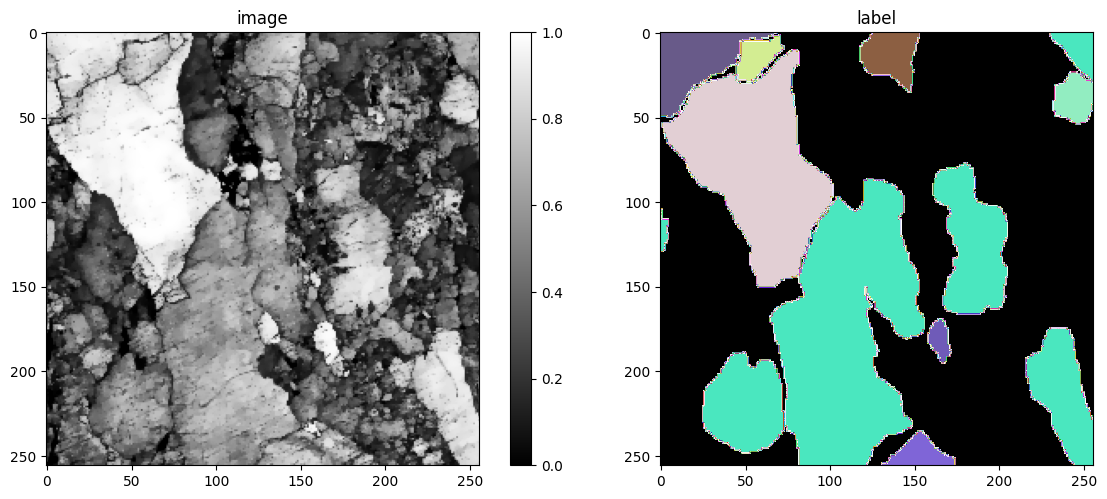

In [42]:
#PLot image and label for some images - sanity check
def plot_img_label(img, lbl, img_title="image", lbl_title="label", **kwargs):
    fig, (ai,al) = plt.subplots(1,2, figsize=(12,5), gridspec_kw=dict(width_ratios=(1.25,1)))
    im = ai.imshow(img, cmap='gray', clim=(0,1))
    print("img.shape",img.shape)
    ai.set_title(img_title)
    fig.colorbar(im, ax=ai)
    al.imshow(lbl, cmap=lbl_cmap)
    print("lbl.shape",lbl.shape)
    al.set_title(lbl_title)
    plt.tight_layout()


i = min(9, len(X)-1)

img, lbl = X[i], Y[i]
assert img.ndim in (2,3)
img = img if (img.ndim==2 or img.shape[-1]==3) else img[...,0]
plot_img_label(img,lbl)


In [43]:
#Check config to get an idea about all parameters
print(Config2D.__doc__)

Configuration for a :class:`StarDist2D` model.

    Parameters
    ----------
    axes : str or None
        Axes of the input images.
    n_rays : int
        Number of radial directions for the star-convex polygon.
        Recommended to use a power of 2 (default: 32).
    n_channel_in : int
        Number of channels of given input image (default: 1).
    grid : (int,int)
        Subsampling factors (must be powers of 2) for each of the axes.
        Model will predict on a subsampled grid for increased efficiency and larger field of view.
    n_classes : None or int
        Number of object classes to use for multi-class predection (use None to disable)
    backbone : str
        Name of the neural network architecture to be used as backbone.
    kwargs : dict
        Overwrite (or add) configuration attributes (see below).


    Attributes
    ----------
    unet_n_depth : int
        Number of U-Net resolution levels (down/up-sampling layers).
    unet_kernel_size : (int,int)
   

In [44]:
#Define the config by setting some parameter values
# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = False and gputools_available()

# 32 is a good default choice (see 1_data.ipynb)
'''n_rays = 64  #Number of radial directions for the star-convex polygon.

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (2,2)

conf = Config2D(
    n_dim=2,
    axes='YXC',
    n_channel_in=1,
    n_channel_out=33,
    train_checkpoint='weights_best.h5',
    train_checkpoint_last='weights_last.h5',
    train_checkpoint_epoch='weights_now.h5',
    n_rays=32,
    grid=grid,
    backbone='unet',
    n_classes=None, unet_n_depth=3,
    unet_kernel_size=(3, 3),
    unet_n_filter_base=32,
    unet_n_conv_per_depth=2,
    unet_pool=(2, 2),
    unet_activation='relu',
    unet_last_activation='relu',
    unet_batch_norm=False,
    unet_dropout=0.0,
    unet_prefix='',
    net_conv_after_unet=128,
    net_input_shape=(None, None, 1),
    net_mask_shape=(None, None, 1),
    train_shape_completion=False,
    train_completion_crop=32,
    train_patch_size=(256, 256),
    train_background_reg=0.0001,
    train_foreground_only=0.9,
    train_sample_cache=True,
    train_dist_loss='mae',
    train_loss_weights=(1, 0.2),
    train_class_weights=(1, 1),
    train_epochs=400,
    train_steps_per_epoch=100,
    #freezing the layers is the same as setting the learn rate to 0
    train_learning_rate=0.0003,
    train_batch_size=4,
    train_n_val_patches=None,
    train_tensorboard=True,
    train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0},
    use_gpu=False
    )'''


conf1 = Config2D (
    n_rays       = 126,
    grid         = (2,2),
    use_gpu      = False and gputools_available(),
    n_channel_in = n_channel,
    train_shape_completion  = False
)

conf2 = Config2D (
    n_rays       = 126,
    grid         = (8,8),
    use_gpu      = False and gputools_available(),
    n_channel_in = n_channel,
    train_shape_completion  = False
)

configArray = []
configArray.append(conf1)
configArray.append(conf2)

print(conf1)
print(conf2)
vars(conf1)

Config2D(n_dim=2, axes='YXC', n_channel_in=1, n_channel_out=127, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', n_rays=126, grid=(2, 2), backbone='unet', n_classes=None, unet_n_depth=3, unet_kernel_size=(3, 3), unet_n_filter_base=32, unet_n_conv_per_depth=2, unet_pool=(2, 2), unet_activation='relu', unet_last_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_prefix='', net_conv_after_unet=128, net_input_shape=(None, None, 1), net_mask_shape=(None, None, 1), train_shape_completion=False, train_completion_crop=32, train_patch_size=(256, 256), train_background_reg=0.0001, train_foreground_only=0.9, train_sample_cache=True, train_dist_loss='mae', train_loss_weights=(1, 0.2), train_class_weights=(1, 1), train_epochs=400, train_steps_per_epoch=100, train_learning_rate=0.0003, train_batch_size=4, train_n_val_patches=None, train_tensorboard=True, train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0}

{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 127,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_rays': 126,
 'grid': (2, 2),
 'backbone': 'unet',
 'n_classes': None,
 'unet_n_depth': 3,
 'unet_kernel_size': (3, 3),
 'unet_n_filter_base': 32,
 'unet_n_conv_per_depth': 2,
 'unet_pool': (2, 2),
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, 1),
 'net_mask_shape': (None, None, 1),
 'train_shape_completion': False,
 'train_completion_crop': 32,
 'train_patch_size': (256, 256),
 'train_background_reg': 0.0001,
 'train_foreground_only': 0.9,
 'train_sample_cache': True,
 'train_dist_loss': 'mae',
 'train_loss_weights': (1, 0.2),
 'train_class_weights': (1, 1),
 'train_epochs': 400,
 'train_steps_per_epoch': 100,
 'train_learning_rate': 0.0003

 97/100 [============================>.] - ETA: 0s - loss: 4.5510 - prob_loss: 0.3353 - dist_loss: 21.0785 - prob_kld: 0.1531 - dist_relevant_mae: 21.0767 - dist_relevant_mse: 1010.6254 - dist_dist_iou_metric: 0.2794

In [45]:
if use_gpu:
    from csbdeep.utils.tf import limit_gpu_memory
    # adjust as necessary: limit GPU memory to be used by TensorFlow to leave some to OpenCL-based computations
    limit_gpu_memory(0.8)
    # alternatively, try this:
    # limit_gpu_memory(None, allow_growth=True)

In [46]:
#Save model to the specified directory
modelsArray = []
for configs in configArray:
  model = StarDist2D(configs, name='stardist_base')
  # Access the underlying Keras model
  new_model = model.keras_model

  # Freeze all layers except the last 3
  for layer in model.keras_model.layers[:-3]:
      layer.trainable = False

  modelsArray.append(model)

  # Display model summary
  #new_model.summary()





#model = StarDist2D(conf, name='stardist_Modifyed', new_model )


 98/100 [============================>.] - ETA: 0s - loss: 4.5643 - prob_loss: 0.3359 - dist_loss: 21.1420 - prob_kld: 0.1531 - dist_relevant_mae: 21.1402 - dist_relevant_mse: 1016.5593 - dist_dist_iou_metric: 0.2789

base_model.py (149): output path for model already exists, files may be overwritten: /content/stardist_base


100/100 [==============================] - ETA: 0s - loss: 4.5430 - prob_loss: 0.3351 - dist_loss: 21.0392 - prob_kld: 0.1528 - dist_relevant_mae: 21.0374 - dist_relevant_mse: 1005.6697 - dist_dist_iou_metric: 0.2796Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.141074, nms_thresh=0.3.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.141074, nms_thresh=0.3.


In [47]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D

import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import math

In [48]:
#Define the network field of view to size larger than the median object size
#?skimage.measure.label
#print("Y.size",Y.size)
#Y = Y[:,:]
model_median_sizes = []
model_fovs = []
for model in modelsArray:
  median_size = calculate_extents(list(Y), np.median)
  #print(f"median object size:      {median_size}")
  median_size = median_size[0:2]
  model_median_sizes.append(median_size)

  fov = np.array(model._axes_tile_overlap('YX'))
  model_fovs.append(fov)

  print(f"median object size:      {median_size}")
  print(f"network field of view :  {fov}")
  if any(median_size > fov):
      print("WARNING: median object size larger than field of view of the neural network.")


100/100 [==============================] - 21s 209ms/step - loss: 4.5430 - prob_loss: 0.3351 - dist_loss: 21.0392 - prob_kld: 0.1528 - dist_relevant_mae: 21.0374 - dist_relevant_mse: 1005.6697 - dist_dist_iou_metric: 0.2796 - val_loss: 3.7855 - val_prob_loss: 0.2761 - val_dist_loss: 17.5471 - val_prob_kld: 0.1438 - val_dist_relevant_mae: 17.5453 - val_dist_relevant_mse: 576.3629 - val_dist_dist_iou_metric: 0.2953 - lr: 3.0000e-04
Epoch 19/20
  2/100 [..............................] - ETA: 17s - loss: 3.9323 - prob_loss: 0.3364 - dist_loss: 17.9796 - prob_kld: 0.1407 - dist_relevant_mae: 17.9779 - dist_relevant_mse: 614.0474 - dist_dist_iou_metric: 0.2835median object size:      [57. 43.]
network field of view :  [94 94]
 15/100 [===>..........................] - ETA: 16s - loss: 4.0873 - prob_loss: 0.3168 - dist_loss: 18.8524 - prob_kld: 0.1490 - dist_relevant_mae: 18.8506 - dist_relevant_mse: 701.2763 - dist_dist_iou_metric: 0.2917median object size:      [57. 43.]
network field of vi

In [49]:
#Define a few augmentation methods
def random_fliprot(img, mask):
    assert img.ndim >= mask.ndim
    axes = tuple(range(mask.ndim))
    perm = tuple(np.random.permutation(axes))
    img = img.transpose(perm + tuple(range(mask.ndim, img.ndim)))
    mask = mask.transpose(perm)
    for ax in axes:
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=ax)
            mask = np.flip(mask, axis=ax)
    return img, mask

def random_intensity_change(img):
    img = img*np.random.uniform(0.6,2) + np.random.uniform(-0.2,0.2)
    return img


def augmenter(x, y):
    """Augmentation of a single input/label image pair.
    x is an input image
    y is the corresponding ground-truth label image
    """

    #x, y = random_fliprot(x, y)
    #x = random_intensity_change(x)
    # add some gaussian noise
    sig = 0.02*np.random.uniform(0,1)
    x = x + sig*np.random.normal(0,1,x.shape)
    #print("x.shape",x.shape)
    #print("y.shape",y.shape)
    return x, y

 16/100 [===>..........................] - ETA: 16s - loss: 4.1211 - prob_loss: 0.3176 - dist_loss: 19.0175 - prob_kld: 0.1495 - dist_relevant_mae: 19.0157 - dist_relevant_mse: 713.6633 - dist_dist_iou_metric: 0.2892img.shape (256, 256)
lbl.shape (256, 256)
 18/100 [====>.........................] - ETA: 15s - loss: 4.4676 - prob_loss: 0.3228 - dist_loss: 20.7237 - prob_kld: 0.1497 - dist_relevant_mae: 20.7218 - dist_relevant_mse: 953.6525 - dist_dist_iou_metric: 0.2832img_aug.shape (256, 256)
lbl_aug.shape (256, 256)
img.shape (256, 256)
 20/100 [=====>........................] - ETA: 15s - loss: 4.4343 - prob_loss: 0.3252 - dist_loss: 20.5456 - prob_kld: 0.1500 - dist_relevant_mae: 20.5437 - dist_relevant_mse: 927.0054 - dist_dist_iou_metric: 0.2831img_aug.shape (256, 256)
lbl_aug.shape (256, 256)
img.shape (256, 256)
 22/100 [=====>........................] - ETA: 14s - loss: 4.3977 - prob_loss: 0.3247 - dist_loss: 20.3650 - prob_kld: 0.1497 - dist_relevant_mae: 20.3631 - dist_relev

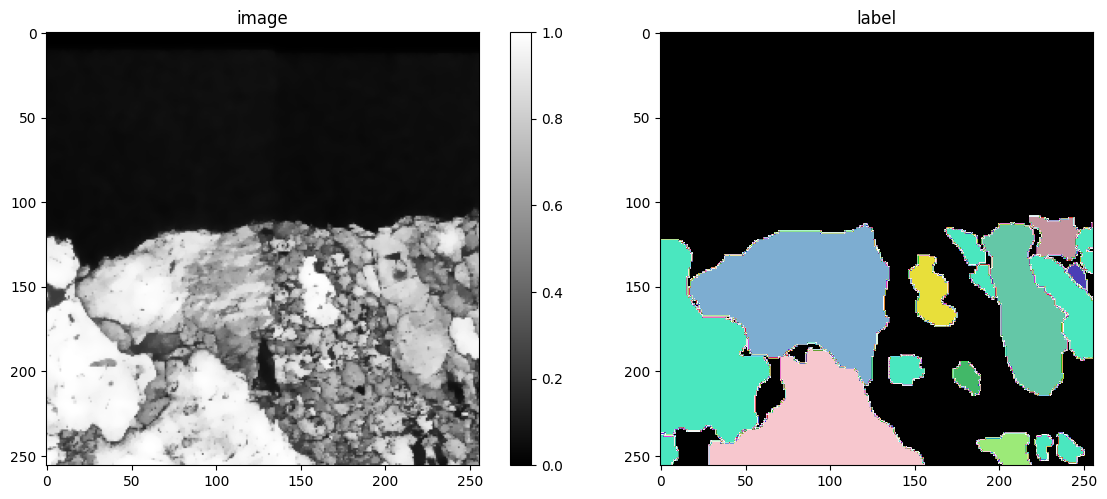

 45/100 [============>.................] - ETA: 10s - loss: 4.5460 - prob_loss: 0.3330 - dist_loss: 21.0653 - prob_kld: 0.1504 - dist_relevant_mae: 21.0635 - dist_relevant_mse: 987.5396 - dist_dist_iou_metric: 0.2770

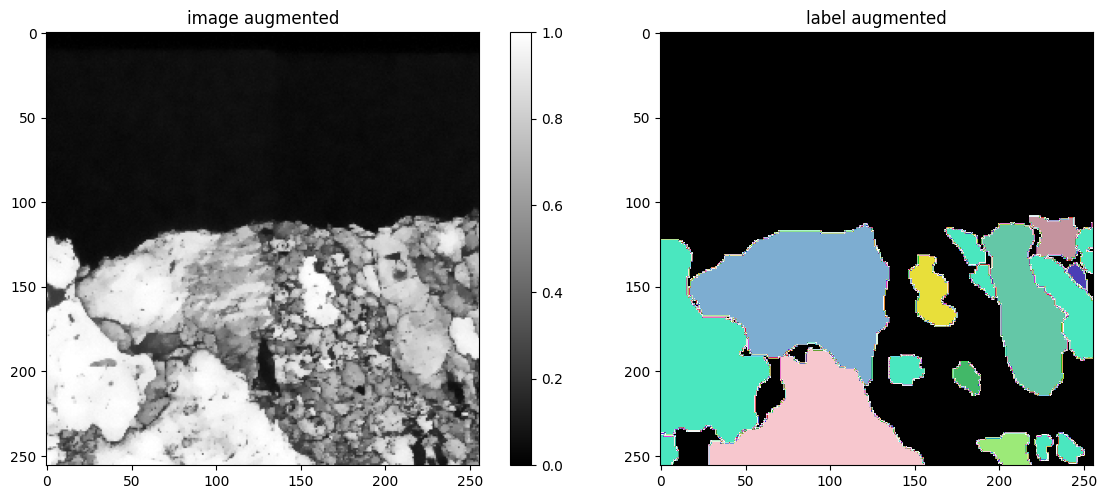

 51/100 [==============>...............] - ETA: 9s - loss: 4.5195 - prob_loss: 0.3295 - dist_loss: 20.9500 - prob_kld: 0.1497 - dist_relevant_mae: 20.9482 - dist_relevant_mse: 972.2887 - dist_dist_iou_metric: 0.2781

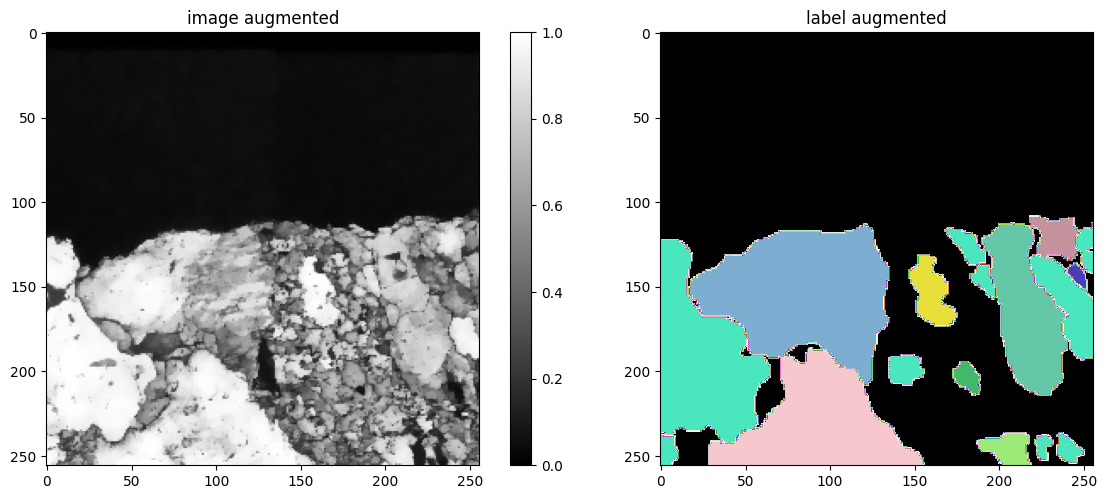

 57/100 [================>.............] - ETA: 8s - loss: 4.4746 - prob_loss: 0.3277 - dist_loss: 20.7345 - prob_kld: 0.1488 - dist_relevant_mae: 20.7326 - dist_relevant_mse: 952.5585 - dist_dist_iou_metric: 0.2806

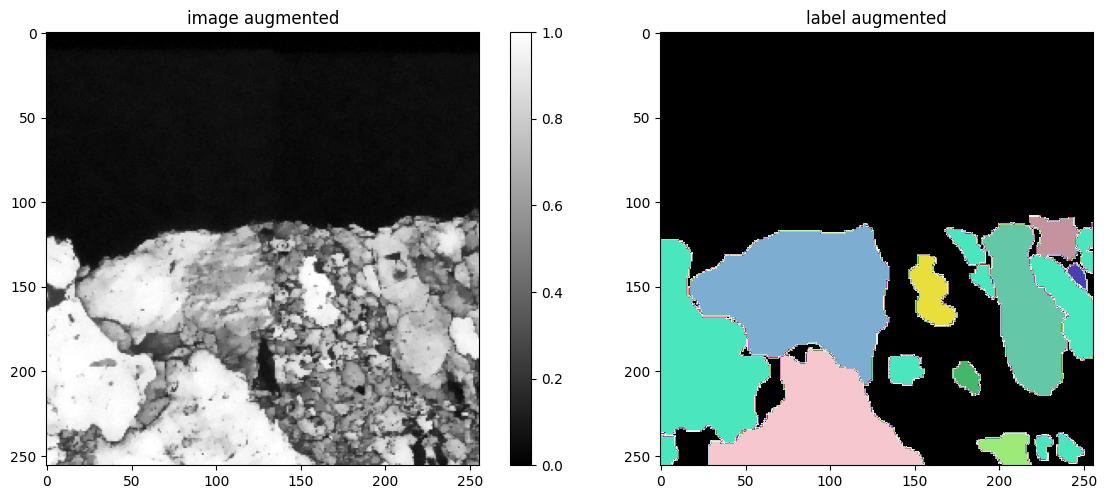

In [50]:
# plot some augmented examples
img, lbl = X[1],Y[1]
#img = img[:,:,0:3]
plot_img_label(img, lbl)
for _ in range(3):
    img_aug, lbl_aug = augmenter(img,lbl)
    print("img_aug.shape",img_aug.shape)
    print("lbl_aug.shape",lbl_aug.shape)

    plot_img_label(img_aug, lbl_aug, img_title="image augmented", lbl_title="label augmented")


In [51]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience = 3, mode = 'max', verbose = 1,restore_best_weights=True)
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5,patience=40)
#{'factor': 0.5, 'patience': 40, min_delta_key: 0}

In [52]:
import logging
import threading
import time

#https://planspace.org/20170324-the_tensorflow_coordinator_for_python_threading/

print("X_val[0].shape",X_val[0].shape)
print("Y_val[0].shape",Y_val[0].shape)
print("X_trn[0].shape",X_trn[0].shape)
print("Y_trn[0].shape",Y_trn[0].shape)

#attempting; to thread our training

#protects our training from a race condition
#lock = threading.Lock()

#creates our lambda function which takes a threadnumber, and a model object
def thread_function(threadNum,model,coord):
#def thread_function(threadNum,model):


  with coord.stop_on_exception():
        while not coord.should_stop():
          logging.info("Thread %s: starting")
          #lock.acquire()
          model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter, epochs=20, steps_per_epoch=100)
          #lock.release()
          logging.info("Thread %s: finishing")



coord = tf.train.Coordinator()
threads = list()
threadnum = 1

for model in modelsArray:
    x = threading.Thread(target=thread_function, args=(threadnum,model,coord))
    #x = threading.Thread(target=thread_function, args=(threadnum,model))
    threads.append(x)
    threadnum = threadnum + 1

try:
    for index, thread in enumerate(threads):
      thread.start()
      #thread.join()
      #coord.request_stop()
      #coord.join(threads)
except Exception as exception:
    coord.request_stop(exception)
finally:
    coord.request_stop()
    coord.join(threads,ignore_live_threads=True)


X_val[0].shape (256, 256)
Y_val[0].shape (256, 256)
X_trn[0].shape (256, 256)
Y_trn[0].shape (256, 256)
 94/100 [===========================>..] - ETA: 1s - loss: 6.9053 - prob_loss: 0.4902 - dist_loss: 32.0753 - prob_kld: 0.2921 - dist_relevant_mae: 32.0753 - dist_relevant_mse: 1974.6655 - dist_dist_iou_metric: 4.2330e-04
Loading network weights from 'weights_best.h5'.
100/100 [==============================] - 52s 458ms/step - loss: 7.4518 - prob_loss: 0.5518 - dist_loss: 34.4998 - prob_kld: 0.3701 - dist_relevant_mae: 34.4998 - dist_relevant_mse: 2125.6870 - dist_dist_iou_metric: 7.1362e-05 - val_loss: 6.5502 - val_prob_loss: 0.4195 - val_dist_loss: 30.6534 - val_prob_kld: 0.2872 - val_dist_relevant_mae: 30.6534 - val_dist_relevant_mse: 1519.6478 - val_dist_dist_iou_metric: 3.5350e-04 - lr: 3.0000e-04
Epoch 2/20
100/100 [==============================] - 18s 185ms/step - loss: 6.8471 - prob_loss: 0.4878 - dist_loss: 31.7967 - prob_kld: 0.2903 - dist_relevant_mae: 31.7966 - dist_rele

In [53]:
print('are threads still running?')
running = True
timer = 0;
while(running):
  timer = timer+1


are threads still running?
100/100 [==============================] - 21s 214ms/step - loss: 5.6035 - prob_loss: 0.4509 - dist_loss: 25.7631 - prob_kld: 0.2531 - dist_relevant_mae: 25.7625 - dist_relevant_mse: 1492.3395 - dist_dist_iou_metric: 0.0728 - val_loss: 4.8160 - val_prob_loss: 0.3795 - val_dist_loss: 22.1825 - val_prob_kld: 0.2367 - val_dist_relevant_mae: 22.1818 - val_dist_relevant_mse: 1002.3122 - val_dist_dist_iou_metric: 0.0892 - lr: 3.0000e-04
Epoch 8/20
100/100 [==============================] - 40s 398ms/step - loss: 6.3548 - prob_loss: 0.4400 - dist_loss: 29.5736 - prob_kld: 0.2594 - dist_relevant_mae: 29.5732 - dist_relevant_mse: 1823.5536 - dist_dist_iou_metric: 0.0474 - val_loss: 5.1364 - val_prob_loss: 0.3814 - val_dist_loss: 23.7750 - val_prob_kld: 0.2490 - val_dist_relevant_mae: 23.7745 - val_dist_relevant_mse: 1097.8352 - val_dist_dist_iou_metric: 0.0751 - lr: 3.0000e-04
Epoch 5/20
100/100 [==============================] - ETA: 0s - loss: 5.6495 - prob_loss: 0.

Exception in thread Thread-14 (thread_function):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-52-d86fca84f3ce>", line 26, in thread_function
  File "/usr/local/lib/python3.10/dist-packages/stardist/models/model2d.py", line 453, in train
    history = fit(iter(self.data_train), validation_data=data_val,
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/h5py/_hl/files.py", line 567, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
  File "/usr/local/lib/python3.10/dist-packages/h5py/_hl/files.py", line 237, in make_fid
    fid = h5f.create(name, h5f.ACC_TRUNC, fapl=fapl, fcpl=fcpl)
  File "h5py/

100/100 [==============================] - 45s 451ms/step - loss: 5.0645 - prob_loss: 0.4485 - dist_loss: 23.0800 - prob_kld: 0.2522 - dist_relevant_mae: 23.0789 - dist_relevant_mse: 1308.9652 - dist_dist_iou_metric: 0.1545 - val_loss: 4.2562 - val_prob_loss: 0.3818 - val_dist_loss: 19.3719 - val_prob_kld: 0.2390 - val_dist_relevant_mae: 19.3707 - val_dist_relevant_mse: 803.7969 - val_dist_dist_iou_metric: 0.1701 - lr: 3.0000e-04
Epoch 10/20
100/100 [==============================] - 28s 279ms/step - loss: 4.8093 - prob_loss: 0.4492 - dist_loss: 21.8005 - prob_kld: 0.2525 - dist_relevant_mae: 21.7992 - dist_relevant_mse: 1167.2485 - dist_dist_iou_metric: 0.1884 - val_loss: 4.0931 - val_prob_loss: 0.3813 - val_dist_loss: 18.5590 - val_prob_kld: 0.2385 - val_dist_relevant_mae: 18.5576 - val_dist_relevant_mse: 735.8437 - val_dist_dist_iou_metric: 0.2018 - lr: 3.0000e-04
Epoch 11/20
100/100 [==============================] - 28s 278ms/step - loss: 4.7078 - prob_loss: 0.4497 - dist_loss: 21

KeyboardInterrupt: ignored

In [54]:

'''print("X_val[0].shape",X_val[0].shape)
print("Y_val[0].shape",Y_val[0].shape)
print("X_trn[0].shape",X_trn[0].shape)
print("Y_trn[0].shape",Y_trn[0].shape)
for model in modelsArray:
  model.prepare_for_training()
  model.callbacks.append(early_stopping)
  model.callbacks.append(learning_rate_reduction)
  model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter, epochs=50, steps_per_epoch=100)'''

'print("X_val[0].shape",X_val[0].shape)\nprint("Y_val[0].shape",Y_val[0].shape)\nprint("X_trn[0].shape",X_trn[0].shape)\nprint("Y_trn[0].shape",Y_trn[0].shape)\nfor model in modelsArray:\n  model.prepare_for_training()\n  model.callbacks.append(early_stopping)\n  model.callbacks.append(learning_rate_reduction)\n  model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter, epochs=50, steps_per_epoch=100)'

In [55]:
#Optimize the thresolds using the trained model
for model in modelsArray:
  model.optimize_thresholds(X_val, Y_val)

NMS threshold = 0.5:  75%|███████▌  | 15/20 [00:12<00:04,  1.17it/s, 0.227 -> 0.000]


Using optimized values: prob_thresh=0.227336, nms_thresh=0.3.
Saving to 'thresholds.json'.


NMS threshold = 0.5:  75%|███████▌  | 15/20 [00:13<00:04,  1.14it/s, 0.152 -> 0.005]


Using optimized values: prob_thresh=0.144725, nms_thresh=0.3.
Saving to 'thresholds.json'.


In [56]:
#Predict on validation images
predictedSets = []
for model in modelsArray:
  Y_val_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
                for x in tqdm(X_val)]
  predictedSets.append(Y_val_pred)


100%|██████████| 14/14 [00:01<00:00,  8.08it/s]


In [57]:
!pip install pillow

img.shape (256, 256)
lbl.shape (256, 256)
img.shape (256, 256)
lbl.shape (256, 256)


100%|██████████| 9/9 [00:00<00:00, 34.08it/s]


img.shape (256, 256)
lbl.shape (256, 256)
img.shape (256, 256)
lbl.shape (256, 256)


100%|██████████| 9/9 [00:00<00:00, 35.78it/s]


2
0
img.shape (256, 256)
lbl.shape (256, 256)
img.shape (256, 256)
lbl.shape (256, 256)


100%|██████████| 9/9 [00:00<00:00, 33.22it/s]


DatasetMatching(criterion='iou', thresh=0.5, fp=751, tp=3, fn=71, precision=0.003978779840848806, recall=0.04054054054054054, accuracy=0.0036363636363636364, f1=0.007246376811594203, n_true=74, n_pred=754, mean_true_score=0.02191300972087963, mean_matched_score=0.5405209064483643, panoptic_quality=0.003916818162669306, by_image=False)

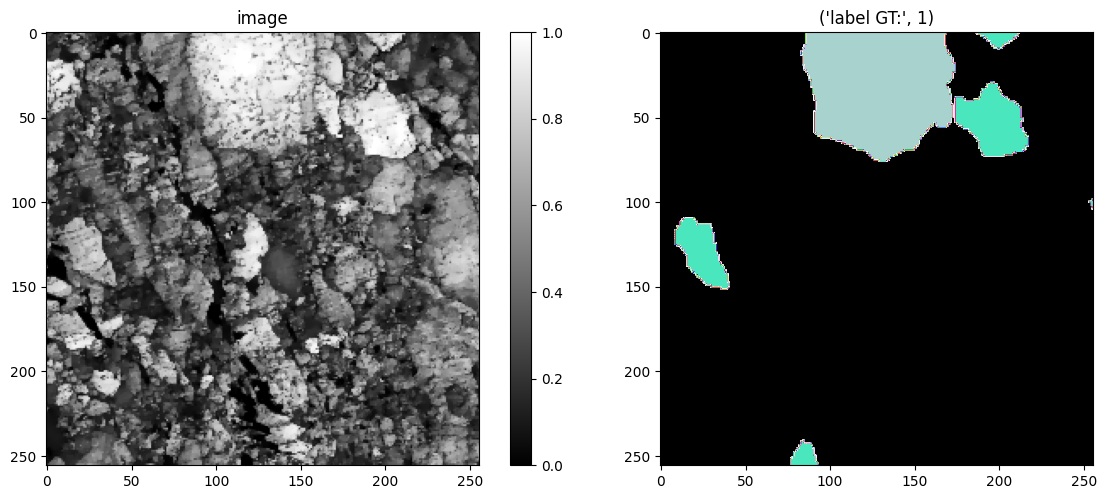

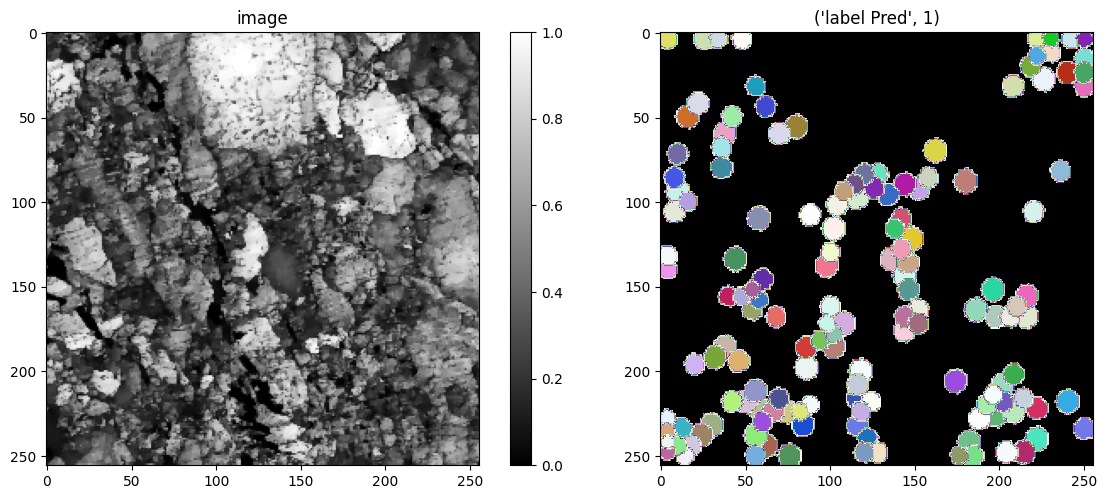

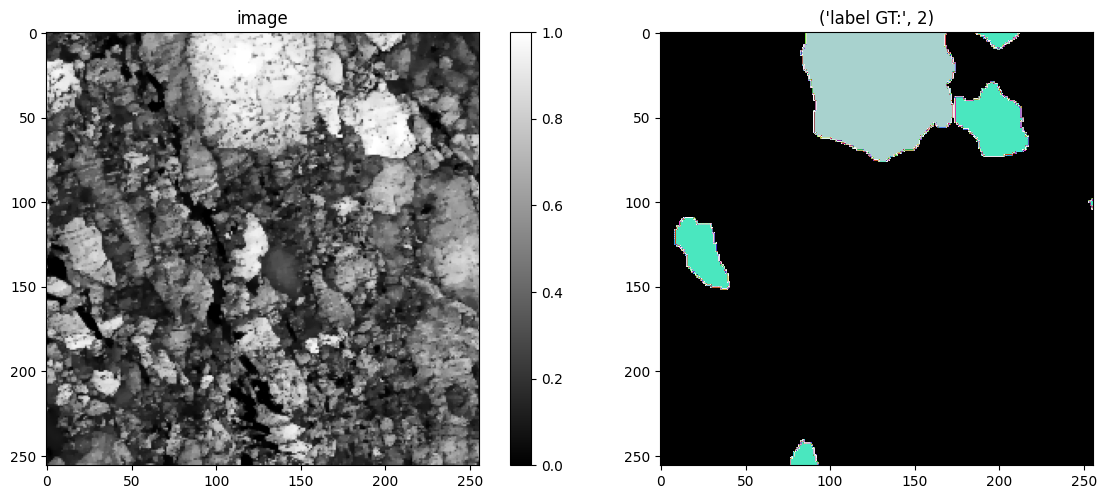

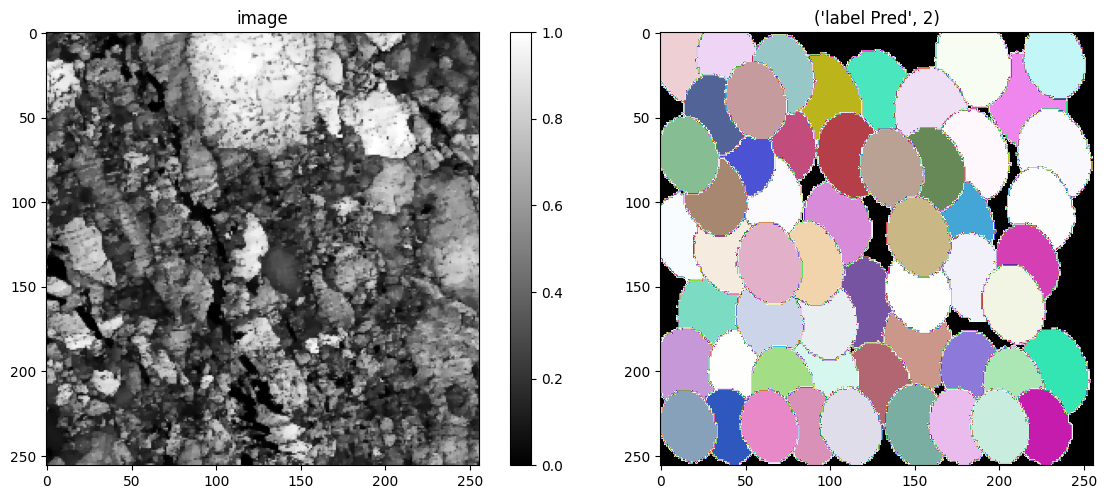

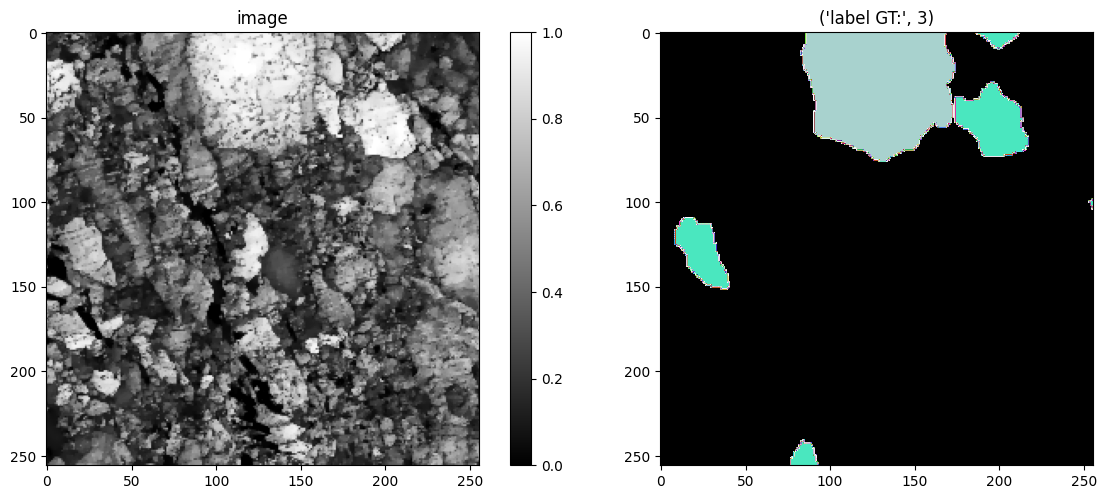

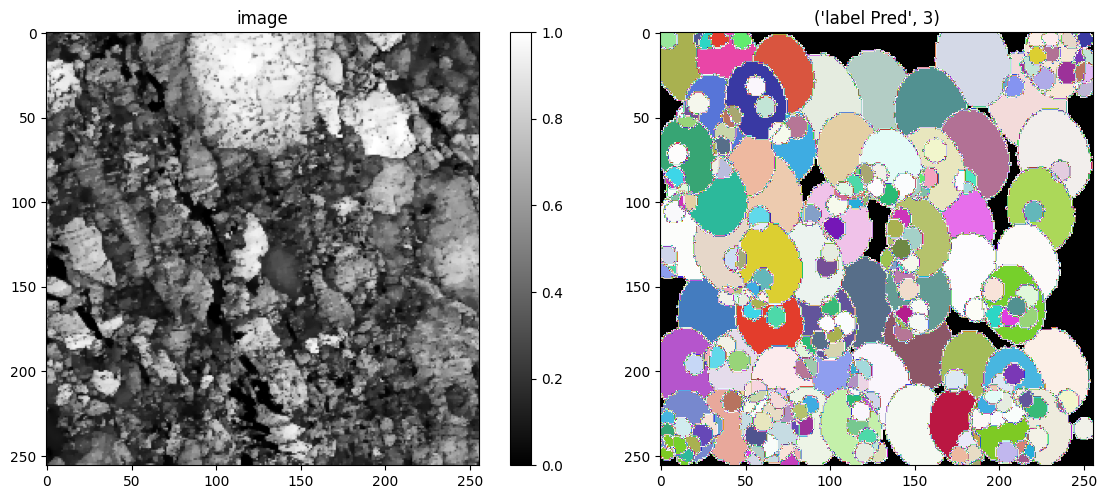

In [58]:
#PLot original labels and predcitions
counter = 1
for Y_val_pred in predictedSets:
  labelGT = "label GT:",counter
  labelPred = "label Pred",counter
  plot_img_label(X_val[0],Y_val[0], lbl_title=labelGT)
  plot_img_label(X_val[0],Y_val_pred[0], lbl_title=labelPred)

  counter = counter+1


  taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
  stats = [matching_dataset(Y_val, Y_val_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

  stats[taus.index(0.5)]

combineResults = []

print(len(predictedSets))

for Y_val_pred_Index in range(len(predictedSets)):
  if(Y_val_pred_Index < len(predictedSets)-1):
    print(Y_val_pred_Index)
    for imageIndex in range(len(predictedSets[Y_val_pred_Index])):
      combinedImg = (predictedSets[Y_val_pred_Index][imageIndex] + predictedSets[Y_val_pred_Index+1][imageIndex])/2
      combineResults.append(combinedImg)
      #np.concatenate((predictedSets[Y_val_pred_Index][imageIndex],predictedSets[Y_val_pred_Index][imageIndex+1]

labelGT = "label GT:",counter
labelPred = "label Pred",counter
plot_img_label(X_val[0],Y_val[0], lbl_title=labelGT)
plot_img_label(X_val[0],combineResults[0], lbl_title=labelPred)




taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y_val, Y_val_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

stats[taus.index(0.5)]

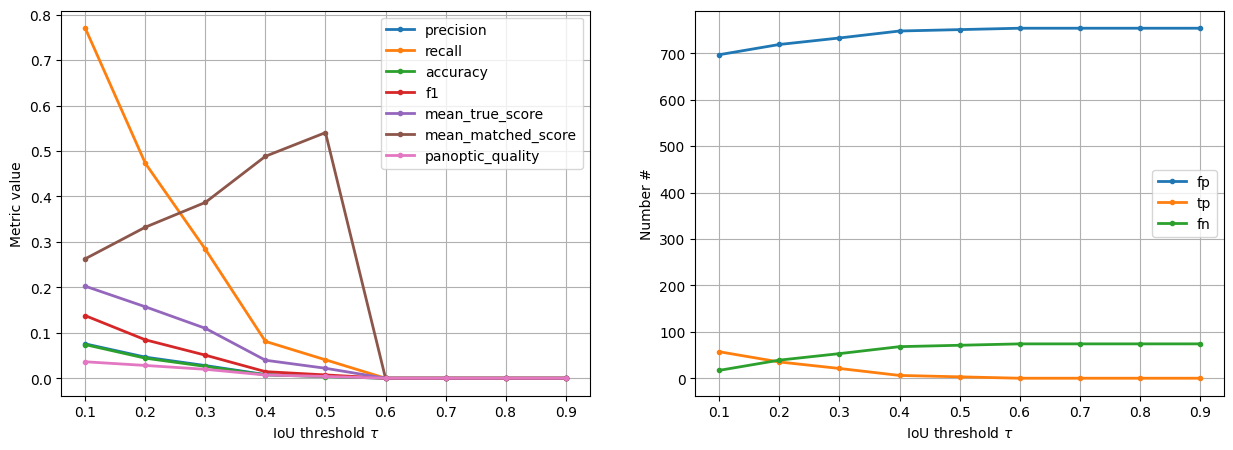

In [59]:

#Plot key metrics
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend();

